In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from funciones import create_data, KNN

In [8]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


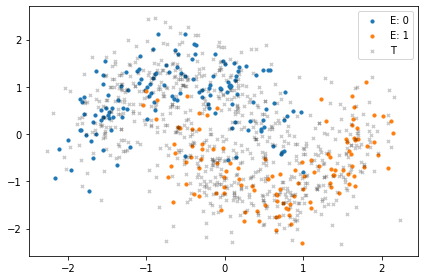

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from funciones import create_data, KNN

E, T = create_data(N=1000)
x, y = E # Use E para realizar validación cruzada
z, w = T # Use las etiquetas w para evaluar sus resultados finales

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
for c in np.unique(y):
    mask = y == c
    ax.scatter(x[mask, 0], x[mask, 1], label=f"E: {c}", s=10)
ax.scatter(z[:, 0], z[:, 1], c='k', s=10, marker='x',  alpha=0.2, label='T')
ax.legend();

In [66]:
E, T = create_data(N=1000)
x, y = E # Use E para realizar validación cruzada
z, w = T # Use las etiquetas w para evaluar sus resultados finales

X = x
Y = y
Z = z

k=5

p=2.

In [32]:
%%cython
import cython
from libc.stdio cimport printf
import array

cimport numpy as npc
import numpy as np

# Tipo fusionado
ctypedef fused TIPO_t:
    npc.float32_t
    npc.float64_t # double

cdef extern from "math.h":
    npc.float32_t sqrtf(npc.float32_t) #Definición para float32
    npc.float64_t sqrt(npc.float64_t) # Definición para float64
    
def KNN_new(TIPO_t [:, ::1] X, Y, Z, int k, double p):
    
    C = np.unique(Y)
    cdef int N = X.shape[0]
    cdef int D = X.shape[1]
    M, _ = Z.shape
    
    #####################
    dist = np.empty(shape=(M, N), dtype=np.double)
    
    cdef double [:, ::1] dist_c = dist
    cdef double suma = 0.0
    cdef int i,j
    
    for i in range(M):
        for j in range(N):
            for n in range(D):
                suma += (abs(Z[i][n] - X[j][n]))**p
            dist_c[i, j] = suma**(1./p)
            suma = 0.0
    

    neighbours = np.argsort(dist_c, axis=1)[:, :k]
    Z_Y = np.zeros(shape=(M, ))
    for i in range(M):
        #lista de zeros de largo C ([0,1])
        criterion_c = np.zeros(shape=(len(C),))
        for c in C:
            for a in range(k):
               
                criterion_c[c] += (1./dist[i][neighbours[i][a]] if Y[neighbours[i][a]] == c else 0)
        if (criterion_c[0]>=criterion_c[1]):
            Z_Y[i] = 0.0
        else:
            Z_Y[i] = 1.0
    return Z_Y


In [77]:
from sklearn.model_selection import train_test_split
#split dataset into train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, stratify=y)

accs = np.zeros(shape=(10,10))
for k in range(1,11):
    acc = 0
    for p in range(1,11):
        knn = KNN_new(x_train, y_train, x_test, k, p)
        #print(len(knn))
        for i in range(len(knn)):
            acc += (1. if knn[i]==y_test[i] else 0.)
        #print(acc)
        accs[k-1, p-1] = (acc/len(knn))
        #print(acc/len(knn))
        acc = 0
print(accs)
ind = np.unravel_index(np.argmax(accs, axis=None), accs.shape)
print(accs[ind])
print('k: {}, p: {}'.format(ind[0]+1, ind[1]+1))

[[0.86 0.86 0.86 0.86 0.86 0.86 0.86 0.86 0.86 0.86]
 [0.86 0.86 0.86 0.86 0.86 0.86 0.86 0.86 0.86 0.86]
 [0.9  0.92 0.92 0.94 0.94 0.94 0.94 0.94 0.94 0.94]
 [0.92 0.92 0.92 0.92 0.92 0.92 0.92 0.92 0.92 0.92]
 [0.92 0.92 0.92 0.92 0.94 0.94 0.94 0.94 0.94 0.94]
 [0.92 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94]
 [0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94]
 [0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94]
 [0.94 0.92 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94]
 [0.94 0.94 0.92 0.92 0.92 0.92 0.92 0.92 0.94 0.94]]
0.94
k: 3, p: 4


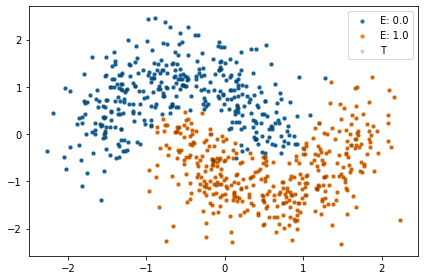

In [65]:
y = KNN_new(X,Y,Z,k,p)
x = z
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
for c in np.unique(y):
    mask = y == c
    ax.scatter(x[mask, 0], x[mask, 1], label=f"E: {c}", s=10)
ax.scatter(z[:, 0], z[:, 1], c='k', s=10, marker='x',  alpha=0.2, label='T')
ax.legend();